In [194]:
import numpy as np
import pandas as pd

## Load Data

In [322]:
data = ['five-mer.csv', 'six-mer.csv', 'seven-mer.csv']

########## EDIT HERE TO CHANGE DATASET ##########
dat_idx = 2 # index to choose the dataset, choose within [0,2]
#################################################

file_path = "../data/" + data[dat_idx]
dat_name = data[dat_idx][:-4] 
df = pd.read_csv(file_path, header=None)

label = '../data/label.txt'
y = np.loadtxt(label, dtype='str')

In [323]:
num_classes = len(np.unique(y))
num_classes

28

In [324]:
num_samples = len(df.index)
print("Number of Samples: ", num_samples)

num_features = len(df.columns)
print("Number of Features: ", num_features)

Number of Samples:  15018
Number of Features:  16384


In [325]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## PCA

In [179]:
from sklearn.decomposition import PCA

# n_components = 512

# pca = PCA(n_components=n_components)
# pca_features = pca.fit_transform(df)
# explained_variance_ratio = sum(pca.explained_variance_ratio_[:n_components])

In [ ]:
lower_bound = round(num_features/20)
upper_bound = round(num_features/3)

explained_variances = [] # for the plot
n_components = [] # for the plot

for i in range (lower_bound,upper_bound, 4):
    pca = PCA(n_components=i)
    pca_features = pca.fit_transform(df)
    explained_variance_ratio = sum(pca.explained_variance_ratio_[:i])
    explained_variances.append(explained_variance_ratio)
    n_components.append(i)
    #print(str(i) + " components")

    if (round(explained_variance_ratio,2) >= 0.90):
        break

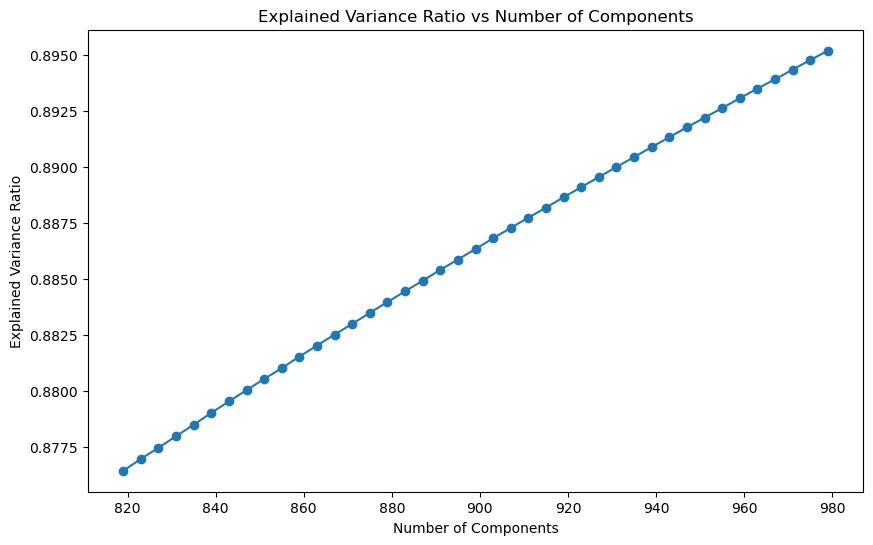

In [191]:
import matplotlib.pyplot as plt

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, marker='o')
plt.title("Explained Variance Ratio vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
#plt.grid(True)
plt.show()

In [182]:
num_selected_features = len(pca_features[0])
print("Number of Selected Features: ", num_selected_features)

Number of Selected Features:  1638


In [183]:
print("PCA Explained Variance Ratio: ", explained_variance_ratio)

PCA Explained Variance Ratio:  0.9425111971788035


In [184]:
pca_features = pd.DataFrame(pca_features)

In [185]:
save_df_name = '../feature_selection/PCA/' + 'pca_' + dat_name
pca_features.to_csv(save_df_name + '.csv', index=False, header=False)

In [186]:
save_txt_name = '../feature_selection/PCA/' + 'pca_' + dat_name
with open(save_txt_name + '.txt', 'w') as f:
    f.write(dat_name + ' Number of Selected Features After PCA: ' + str(num_selected_features) + "\n")
    f.write(dat_name + ' PCA Cumulative Explained Variance Ratio: ' + str(explained_variance_ratio) )

## LR-LASSO

In [188]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression with L1 regularization for feature selection
log_reg = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear').fit(df, y)

# Mask for selecting features
lasso_mask = log_reg.coef_.sum(axis=0) != 0
selected_features_lasso = df.columns[lasso_mask]

save_df_name = '../feature_selection/LASSO/' + 'lasso_' + dat_name


In [189]:
df[selected_features_lasso].to_csv(save_df_name + '.csv', index=False, header=False)

## 1-D CNN

In [326]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FS_1DCNN(nn.Module):
    def __init__(self, num_features, output_size=640):
        super(FS_1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool1d(2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.pool3 = nn.MaxPool1d(2, stride=2)
        self.fc1 = nn.Linear(output_size, 100)
        self.fc2 = nn.Linear(100, num_classes)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)  # Use the defined pooling layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # Use the defined pooling layer
        x = F.relu(self.conv3(x))
        x = self.pool3(x)  # Use the defined pooling layer

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [327]:
X = np.array(df)
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1]) #(num_samples, 1, num_features)

# Convert to pytorch tensor
X_tensor = torch.tensor(X_reshaped, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [328]:
dummy_input = torch.randn(1, 1, num_features)
model = FS_1DCNN(num_features)

with torch.no_grad():
    dummy_output = dummy_input
    for layer in [model.conv1, model.pool1, model.conv2,model.pool2, model.conv3, model.pool3]:  # include all conv and pooling layers
        dummy_output = layer(dummy_output)

    dummy_output = dummy_output.view(dummy_output.size(0), -1)

output_size = dummy_output.shape[1]
print("Number of CNN selected features: ", output_size)

Number of CNN selected features:  4800


In [329]:
model = FS_1DCNN(num_features,output_size=output_size)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training
num_epochs = 100  
for epoch in range(num_epochs):
    # fp
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # bp
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 3.3834
Epoch [2/100], Loss: 3.1143
Epoch [3/100], Loss: 2.8396
Epoch [4/100], Loss: 2.5283
Epoch [5/100], Loss: 2.1932
Epoch [6/100], Loss: 1.8768
Epoch [7/100], Loss: 1.6494
Epoch [8/100], Loss: 1.5808
Epoch [9/100], Loss: 1.6435
Epoch [10/100], Loss: 1.7223
Epoch [11/100], Loss: 1.7492
Epoch [12/100], Loss: 1.7193
Epoch [13/100], Loss: 1.6520
Epoch [14/100], Loss: 1.5665
Epoch [15/100], Loss: 1.4838
Epoch [16/100], Loss: 1.4204
Epoch [17/100], Loss: 1.3849
Epoch [18/100], Loss: 1.3765
Epoch [19/100], Loss: 1.3870
Epoch [20/100], Loss: 1.4050
Epoch [21/100], Loss: 1.4198
Epoch [22/100], Loss: 1.4255
Epoch [23/100], Loss: 1.4209
Epoch [24/100], Loss: 1.4079
Epoch [25/100], Loss: 1.3897
Epoch [26/100], Loss: 1.3708
Epoch [27/100], Loss: 1.3551
Epoch [28/100], Loss: 1.3455
Epoch [29/100], Loss: 1.3430
Epoch [30/100], Loss: 1.3460
Epoch [31/100], Loss: 1.3518
Epoch [32/100], Loss: 1.3569
Epoch [33/100], Loss: 1.3592
Epoch [34/100], Loss: 1.3576
Epoch [35/100], Loss: 1

In [330]:
def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        features = model.conv1(data)
        features = model.pool1(features)
        features = model.conv2(features)
        features = model.pool2(features)  
        features = model.conv3(features)
        features = model.pool3(features)
        features = features.view(features.size(0), -1)  # flatten
    return features

extracted_features = extract_features(X_tensor, model)

In [331]:
extracted_features_np = extracted_features.numpy()
cnn_selected_features_df = pd.DataFrame(extracted_features_np)

In [332]:
save_df_name = '../feature_selection/1D-CNN/' + '1dcnn_' + dat_name
cnn_selected_features_df.to_csv(save_df_name + '.csv', index=False, header=False)